In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)


In [2]:
df = pd.read_csv('D:\My projects\customer_segmentation_project\data\processed\step6_evaluated_clusters.csv')
print(f"✓ Loaded data: {df.shape}")

n_clusters = len(df['Final_ML_Cluster'].unique())
print(f"✓ Number of clusters: {n_clusters}")

✓ Loaded data: (2229, 75)
✓ Number of clusters: 2


In [3]:
cluster_sizes = df['Final_ML_Cluster'].value_counts().sort_index()
for cluster_id in range(n_clusters):
    size = cluster_sizes[cluster_id]
    pct = (size / len(df)) * 100
    print(f"Cluster {cluster_id}: {size:4d} customers ({pct:5.2f}%)")

Cluster 0: 1576 customers (70.70%)
Cluster 1:  653 customers (29.30%)


In [4]:
# DEFINE FEATURE CATEGORIES FOR PROFILING
feature_categories = {
    'RFM_Metrics': ['R_Score', 'F_Score', 'M_Score', 'Recency', 'Total_Purchases', 'Total_Spending'],
    
    'Demographics': ['Age', 'Income', 'Education_Level', 'Family_Size', 'Has_Children', 
                     'Kidhome', 'Teenhome'],
    
    'Spending_Behavior': ['Avg_Order_Value', 'Purchase_Frequency_Rate', 'Customer_Tenure_Days',
                          'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                          'MntSweetProducts', 'MntGoldProds'],
    
    'Product_Preferences': ['Wine_Ratio', 'Meat_Ratio', 'Product_Diversity', 
                           'Premium_Product_Ratio'],
    
    'Channel_Preferences': ['Web_Purchase_Ratio', 'Store_Purchase_Ratio', 
                           'NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases'],
    
    'Engagement': ['Campaign_Acceptance_Rate', 'NumWebVisitsMonth', 'Has_Complained',
                   'Engagement_Score', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                   'AcceptedCmp4', 'AcceptedCmp5', 'Response'],
    
    'Value_Metrics': ['CLV_Estimate', 'Customer_Value_Score'],
    
    'Binary_Flags': ['Is_High_Spender', 'Is_Active', 'Is_Campaign_Responder',
                     'Is_Web_Shopper', 'Is_Deal_Seeker']
}

# Filter to only available features
for category, features in feature_categories.items():
    available = [f for f in features if f in df.columns]
    feature_categories[category] = available
    print(f"  {category}: {len(available)} features")

  RFM_Metrics: 6 features
  Demographics: 7 features
  Spending_Behavior: 9 features
  Product_Preferences: 4 features
  Channel_Preferences: 5 features
  Engagement: 10 features
  Value_Metrics: 2 features
  Binary_Flags: 5 features


In [5]:
# CLUSTER PROFILING - SUMMARY STATISTICS
key_metrics = [
    'Age', 'Income', 'Total_Spending', 'Total_Purchases', 'Avg_Order_Value',
    'Customer_Tenure_Days', 'R_Score', 'F_Score', 'M_Score',
    'CLV_Estimate', 'Campaign_Acceptance_Rate', 'Engagement_Score'
]

# Filter to available metrics
available_metrics = [m for m in key_metrics if m in df.columns]

# Create profile dataframe
cluster_profiles = df.groupby('Final_ML_Cluster')[available_metrics].agg(['mean', 'median', 'std'])
cluster_profiles = cluster_profiles.round(2)

print("\nCluster Profiles (Key Metrics):")
print(cluster_profiles)

# Save detailed profiles
cluster_profiles.to_csv('D://My projects/customer_segmentation_project/outputs/reports/step7_cluster_profiles.csv')
print("\n✓ Saved cluster profiles")



Cluster Profiles (Key Metrics):
                    Age                  Income                     \
                   mean median    std      mean   median       std   
Final_ML_Cluster                                                     
0                 54.58   53.0  11.09  42425.10  41998.5  16172.80   
1                 56.39   56.0  13.00  73809.97  74268.0  10997.12   

                 Total_Spending                 Total_Purchases  ... M_Score  \
                           mean  median     std            mean  ...     std   
Final_ML_Cluster                                                 ...           
0                        292.03   136.0  317.93           12.34  ...    1.08   
1                       1362.19  1336.0  423.40           20.97  ...    0.59   

                 CLV_Estimate                  Campaign_Acceptance_Rate  \
                         mean   median     std                     mean   
Final_ML_Cluster                                                 

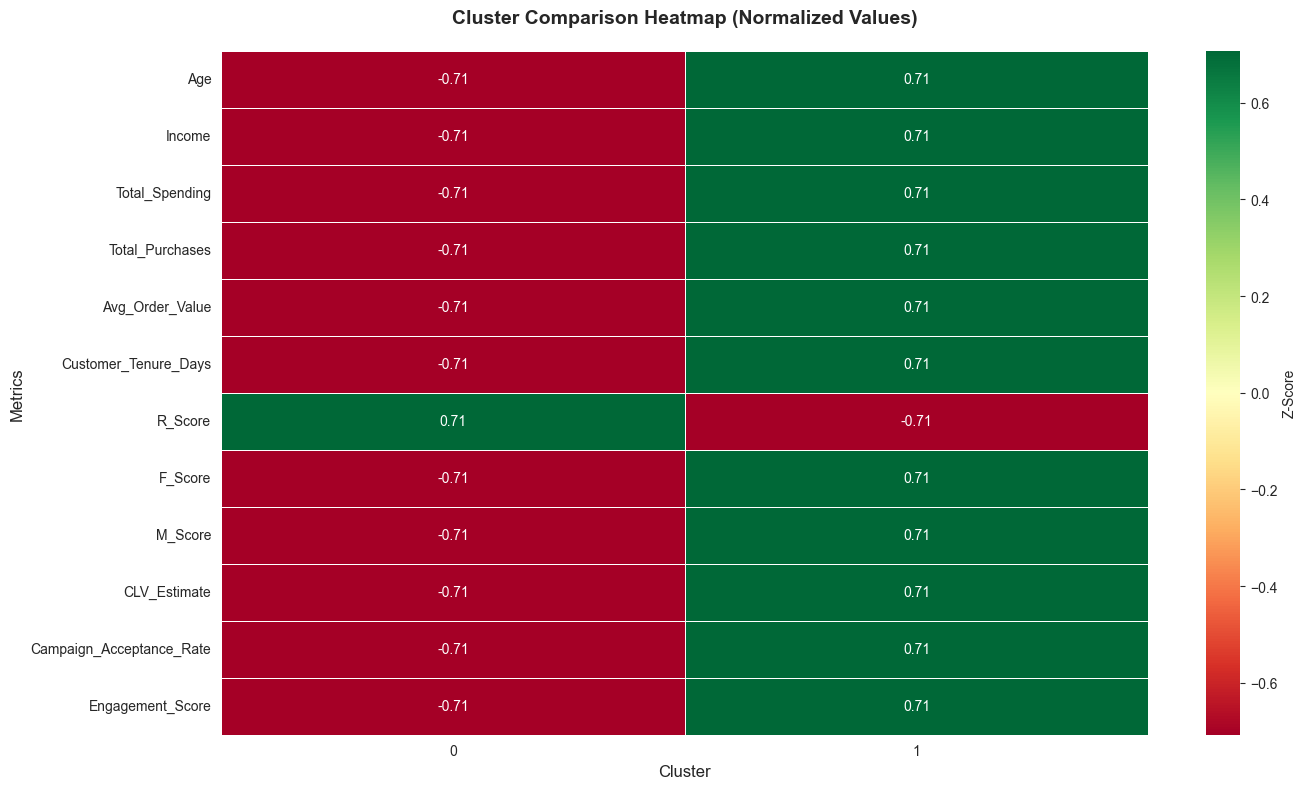

In [6]:
# CLUSTER COMPARISON - HEATMAP
cluster_means = df.groupby('Final_ML_Cluster')[available_metrics].mean()
cluster_means_normalized = (cluster_means - cluster_means.mean()) / cluster_means.std()

# Create heatmap
plt.figure(figsize=(14, max(8, n_clusters * 1.2)))
sns.heatmap(cluster_means_normalized.T, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, cbar_kws={'label': 'Z-Score'}, linewidths=0.5)
plt.title('Cluster Comparison Heatmap (Normalized Values)', 
          fontweight='bold', fontsize=14, pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Metrics', fontsize=12)
plt.tight_layout()
plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step7_cluster_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

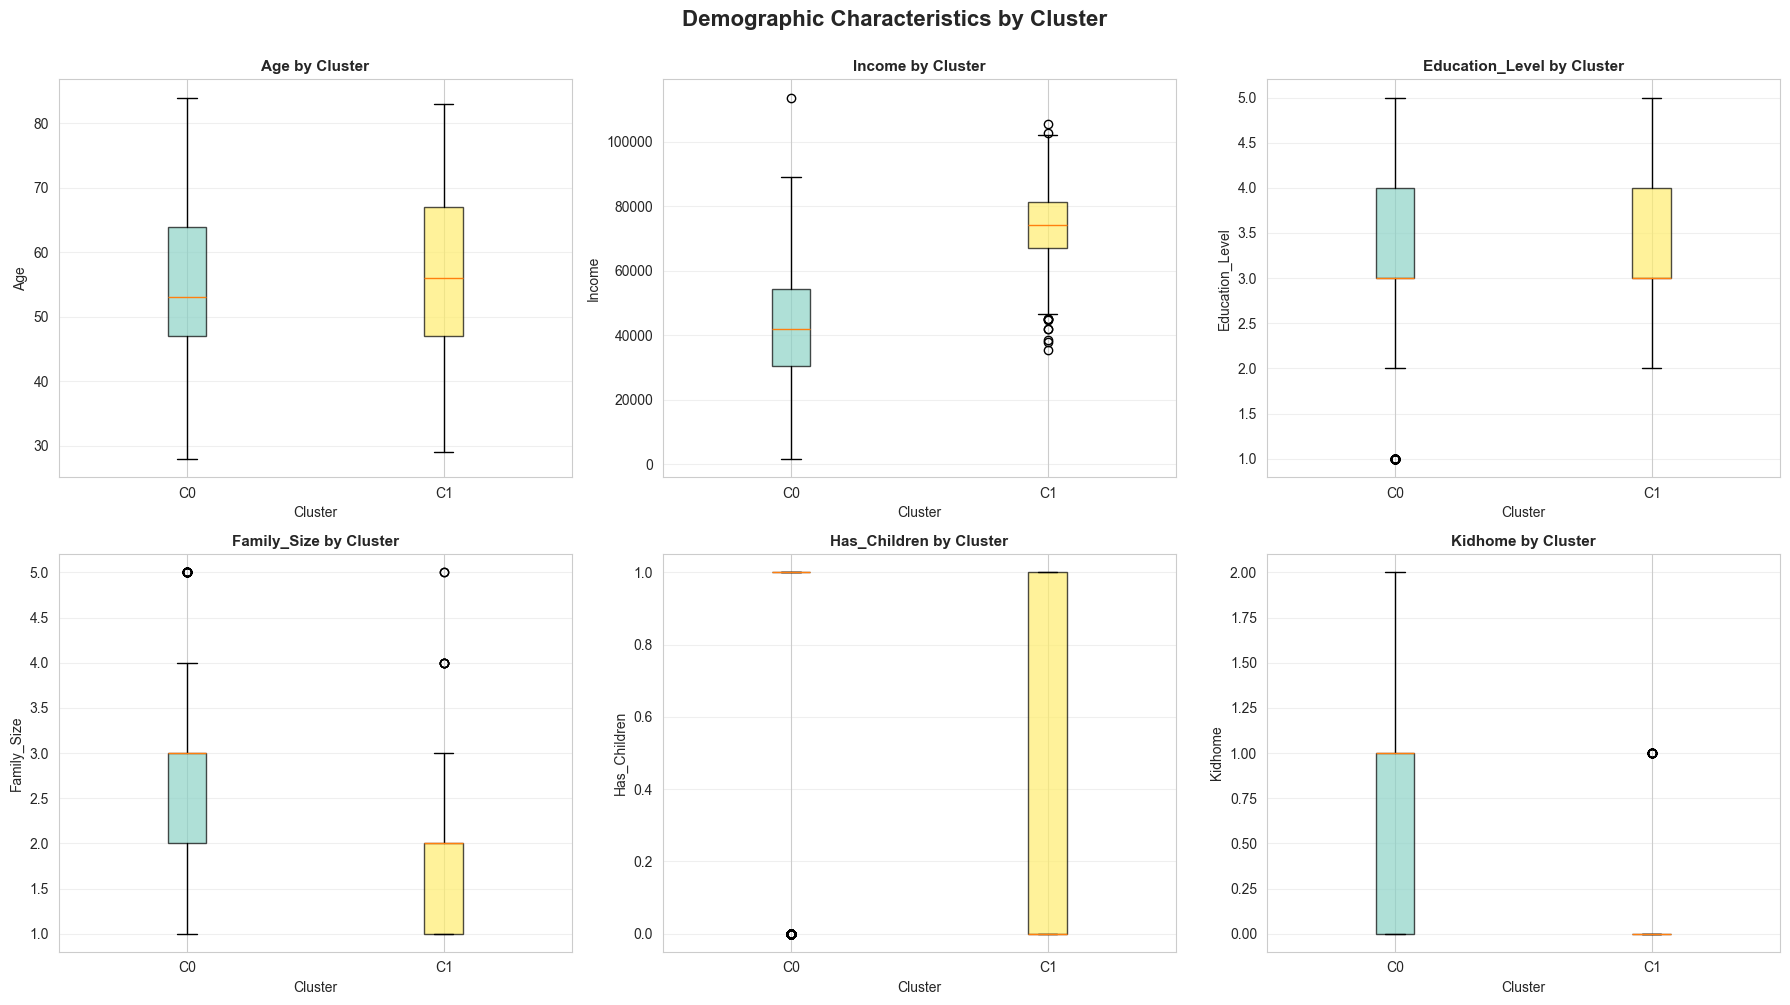

In [7]:
#  DEMOGRAPHIC ANALYSIS BY CLUSTER
demographic_features = feature_categories['Demographics']
if demographic_features:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    colors = plt.cm.Set3(np.linspace(0, 1, n_clusters))
    
    for idx, feat in enumerate(demographic_features[:6]):
        if feat in df.columns:
            cluster_data = [df[df['Final_ML_Cluster'] == i][feat].dropna() for i in range(n_clusters)]
            
            bp = axes[idx].boxplot(cluster_data, labels=[f'C{i}' for i in range(n_clusters)],
                                   patch_artist=True)
            
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            axes[idx].set_xlabel('Cluster', fontsize=10)
            axes[idx].set_ylabel(feat, fontsize=10)
            axes[idx].set_title(f'{feat} by Cluster', fontweight='bold', fontsize=11)
            axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Hide unused subplots
    for idx in range(len(demographic_features), 6):
        axes[idx].axis('off')
    
    plt.suptitle('Demographic Characteristics by Cluster', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step7_demographics.png', dpi=300, bbox_inches='tight')
    plt.show()

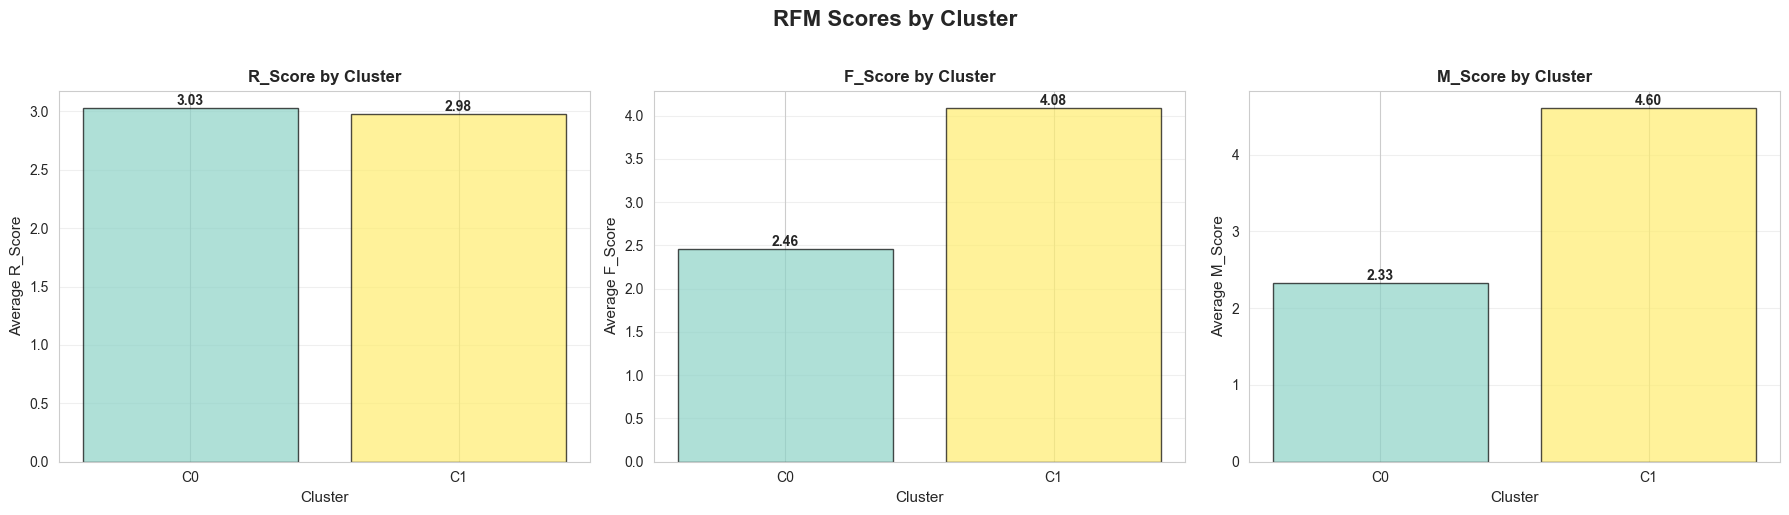


RFM Summary by Cluster:
----------------------------------------------------------------------
                  R_Score  F_Score  M_Score
Final_ML_Cluster                           
0                    3.03     2.46     2.33
1                    2.98     4.08     4.60


In [8]:
#  RFM ANALYSIS BY CLUSTER
rfm_features = ['R_Score', 'F_Score', 'M_Score']
available_rfm = [f for f in rfm_features if f in df.columns]

if available_rfm:
    fig, axes = plt.subplots(1, len(available_rfm), figsize=(6*len(available_rfm), 5))
    if len(available_rfm) == 1:
        axes = [axes]
    
    for idx, feat in enumerate(available_rfm):
        cluster_means_rfm = df.groupby('Final_ML_Cluster')[feat].mean()
        
        bars = axes[idx].bar(range(n_clusters), cluster_means_rfm.values, 
                            color=colors, alpha=0.7, edgecolor='black')
        axes[idx].set_xlabel('Cluster', fontsize=11)
        axes[idx].set_ylabel(f'Average {feat}', fontsize=11)
        axes[idx].set_title(f'{feat} by Cluster', fontweight='bold', fontsize=12)
        axes[idx].set_xticks(range(n_clusters))
        axes[idx].set_xticklabels([f'C{i}' for i in range(n_clusters)])
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.2f}',
                          ha='center', va='bottom', fontweight='bold')
    
    plt.suptitle('RFM Scores by Cluster', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step7_rfm_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Print RFM summary
print("\nRFM Summary by Cluster:")
print("-" * 70)
rfm_summary = df.groupby('Final_ML_Cluster')[available_rfm].mean()
print(rfm_summary.round(2))

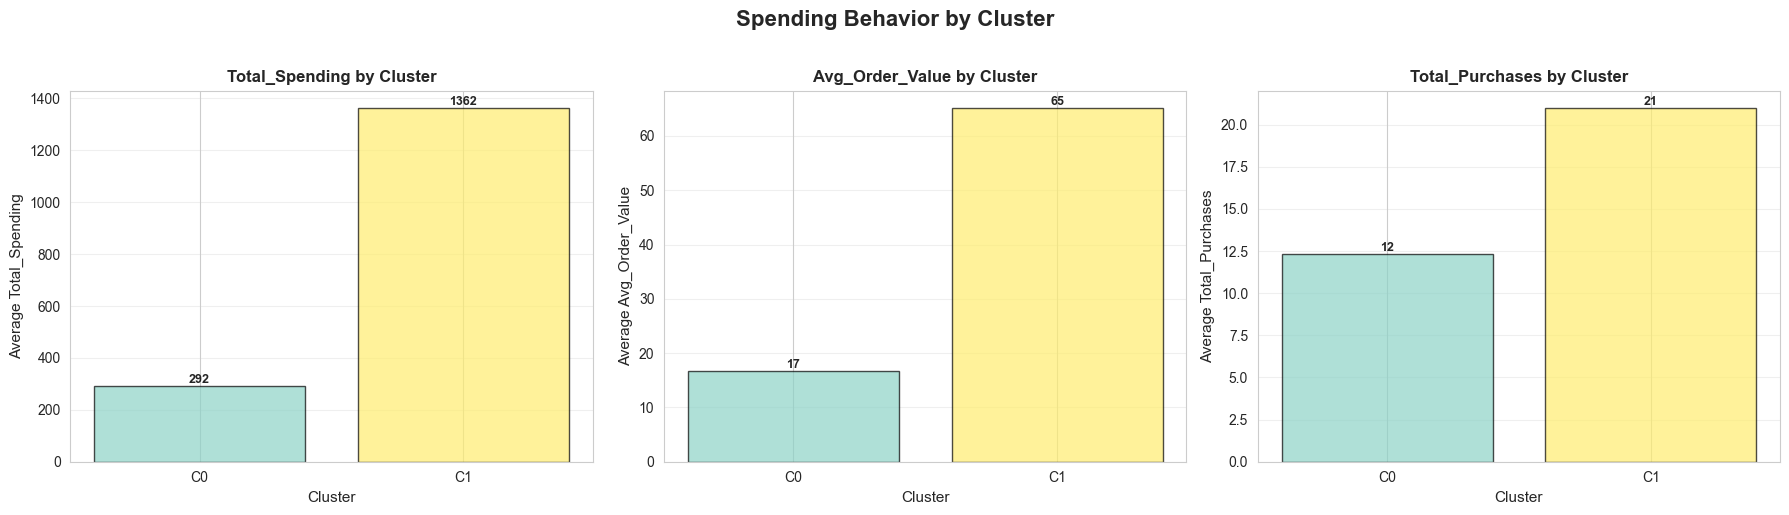

In [9]:
#  SPENDING BEHAVIOR ANALYSIS
spending_features = ['Total_Spending', 'Avg_Order_Value', 'Total_Purchases']
available_spending = [f for f in spending_features if f in df.columns]

if available_spending:
    fig, axes = plt.subplots(1, len(available_spending), figsize=(6*len(available_spending), 5))
    if len(available_spending) == 1:
        axes = [axes]
    
    for idx, feat in enumerate(available_spending):
        cluster_means_spend = df.groupby('Final_ML_Cluster')[feat].mean()
        
        bars = axes[idx].bar(range(n_clusters), cluster_means_spend.values,
                            color=colors, alpha=0.7, edgecolor='black')
        axes[idx].set_xlabel('Cluster', fontsize=11)
        axes[idx].set_ylabel(f'Average {feat}', fontsize=11)
        axes[idx].set_title(f'{feat} by Cluster', fontweight='bold', fontsize=12)
        axes[idx].set_xticks(range(n_clusters))
        axes[idx].set_xticklabels([f'C{i}' for i in range(n_clusters)])
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.0f}',
                          ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.suptitle('Spending Behavior by Cluster', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step7_spending_behavior.png', dpi=300, bbox_inches='tight')
    plt.show()

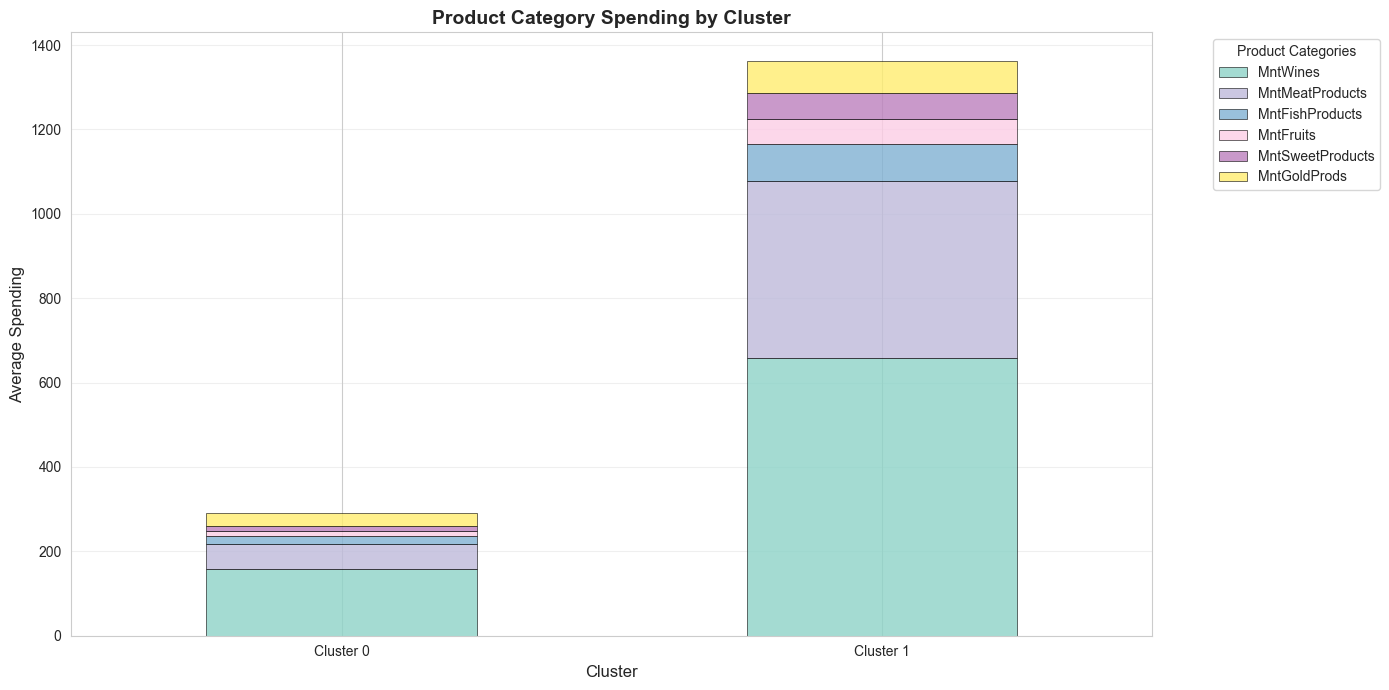

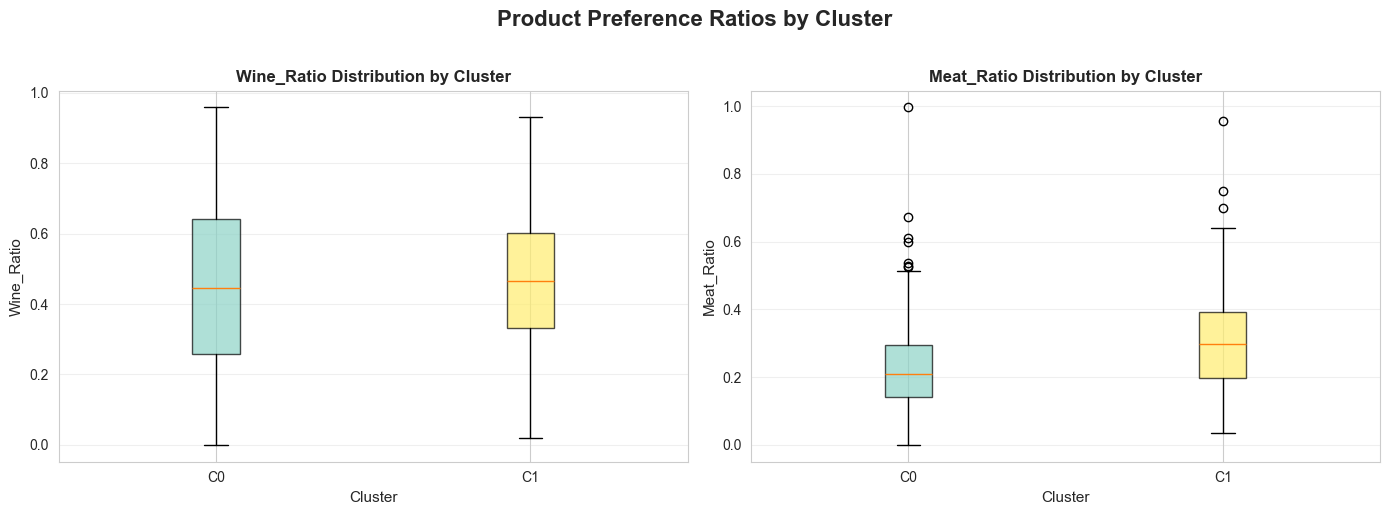

In [10]:
#  PRODUCT PREFERENCES BY CLUSTER
product_features = ['MntWines', 'MntMeatProducts', 'MntFishProducts', 
                   'MntFruits', 'MntSweetProducts', 'MntGoldProds']
available_products = [f for f in product_features if f in df.columns]

if available_products:
    # Stacked bar chart
    product_spending = df.groupby('Final_ML_Cluster')[available_products].mean()
    
    fig, ax = plt.subplots(figsize=(14, 7))
    product_spending.plot(kind='bar', stacked=True, ax=ax, colormap='Set3', 
                         alpha=0.8, edgecolor='black', linewidth=0.5)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel('Average Spending', fontsize=12)
    ax.set_title('Product Category Spending by Cluster', fontweight='bold', fontsize=14)
    ax.legend(title='Product Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels([f'Cluster {i}' for i in range(n_clusters)], rotation=0)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step7_product_preferences.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Product ratios
    ratio_features = ['Wine_Ratio', 'Meat_Ratio']
    available_ratios = [f for f in ratio_features if f in df.columns]
    
    if available_ratios:
        fig, axes = plt.subplots(1, len(available_ratios), 
                                figsize=(7*len(available_ratios), 5))
        if len(available_ratios) == 1:
            axes = [axes]
        
        for idx, feat in enumerate(available_ratios):
            cluster_data = [df[df['Final_ML_Cluster'] == i][feat].dropna() for i in range(n_clusters)]
            
            bp = axes[idx].boxplot(cluster_data, labels=[f'C{i}' for i in range(n_clusters)],
                                   patch_artist=True)
            
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
            
            axes[idx].set_xlabel('Cluster', fontsize=11)
            axes[idx].set_ylabel(feat, fontsize=11)
            axes[idx].set_title(f'{feat} Distribution by Cluster', 
                               fontweight='bold', fontsize=12)
            axes[idx].grid(True, alpha=0.3, axis='y')
        
        plt.suptitle('Product Preference Ratios by Cluster', 
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step7_product_ratios.png', 
                    dpi=300, bbox_inches='tight')
        plt.show()

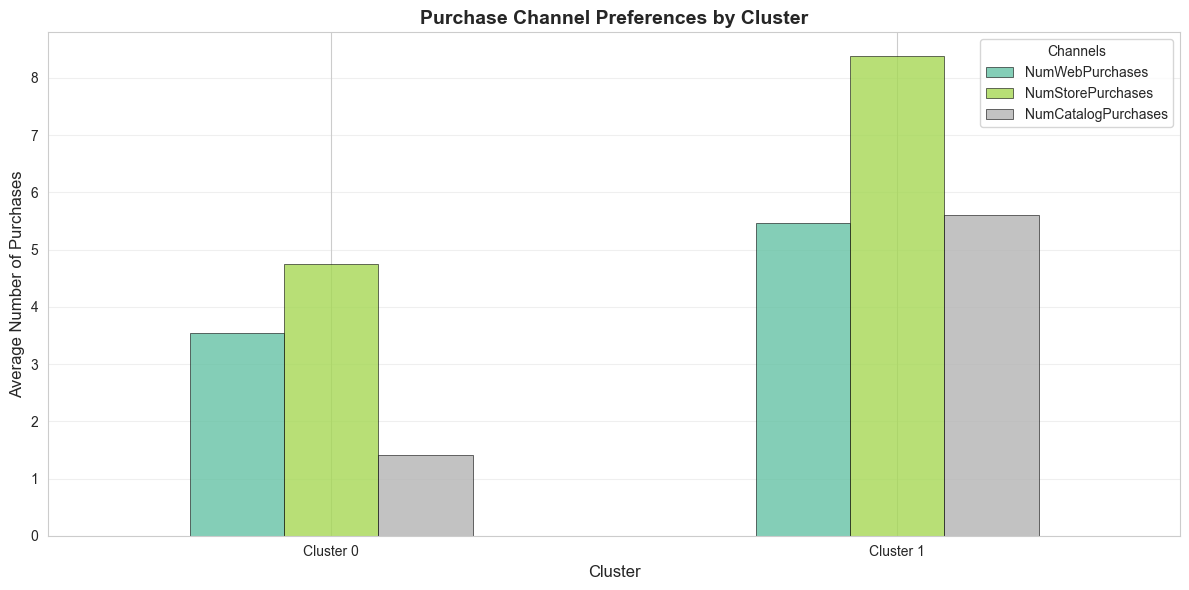

In [11]:
# CHANNEL PREFERENCES BY CLUSTER
channel_features = ['NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases']
available_channels = [f for f in channel_features if f in df.columns]

if available_channels:
    channel_means = df.groupby('Final_ML_Cluster')[available_channels].mean()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    channel_means.plot(kind='bar', ax=ax, colormap='Set2', alpha=0.8,
                       edgecolor='black', linewidth=0.5)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel('Average Number of Purchases', fontsize=12)
    ax.set_title('Purchase Channel Preferences by Cluster', 
                 fontweight='bold', fontsize=14)
    ax.legend(title='Channels', loc='upper right')
    ax.set_xticklabels([f'Cluster {i}' for i in range(n_clusters)], rotation=0)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step7_channel_preferences.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

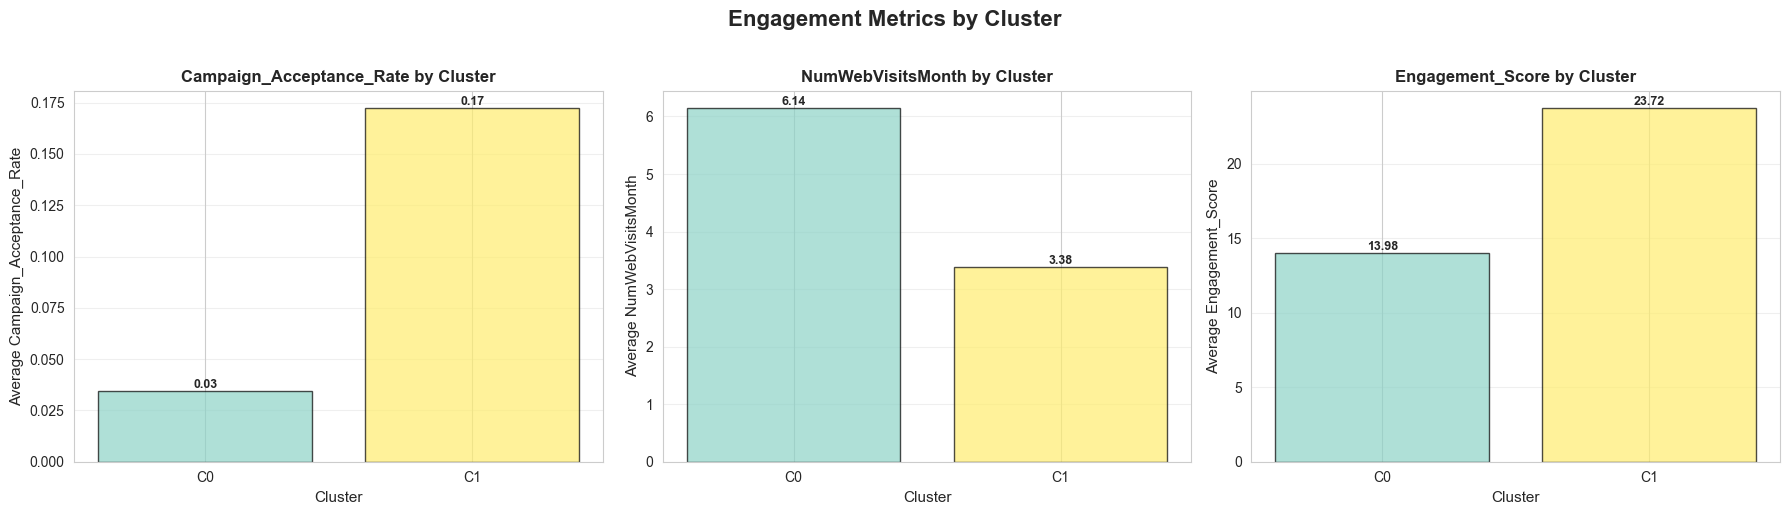

In [12]:
#  ENGAGEMENT ANALYSIS BY CLUSTER
engagement_features = ['Campaign_Acceptance_Rate', 'NumWebVisitsMonth', 
                       'Engagement_Score']
available_engagement = [f for f in engagement_features if f in df.columns]

if available_engagement:
    fig, axes = plt.subplots(1, len(available_engagement), 
                            figsize=(6*len(available_engagement), 5))
    if len(available_engagement) == 1:
        axes = [axes]
    
    for idx, feat in enumerate(available_engagement):
        cluster_means_eng = df.groupby('Final_ML_Cluster')[feat].mean()
        
        bars = axes[idx].bar(range(n_clusters), cluster_means_eng.values,
                            color=colors, alpha=0.7, edgecolor='black')
        axes[idx].set_xlabel('Cluster', fontsize=11)
        axes[idx].set_ylabel(f'Average {feat}', fontsize=11)
        axes[idx].set_title(f'{feat} by Cluster', fontweight='bold', fontsize=12)
        axes[idx].set_xticks(range(n_clusters))
        axes[idx].set_xticklabels([f'C{i}' for i in range(n_clusters)])
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.2f}',
                          ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.suptitle('Engagement Metrics by Cluster', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step7_engagement.png', dpi=300, bbox_inches='tight')
    plt.show()

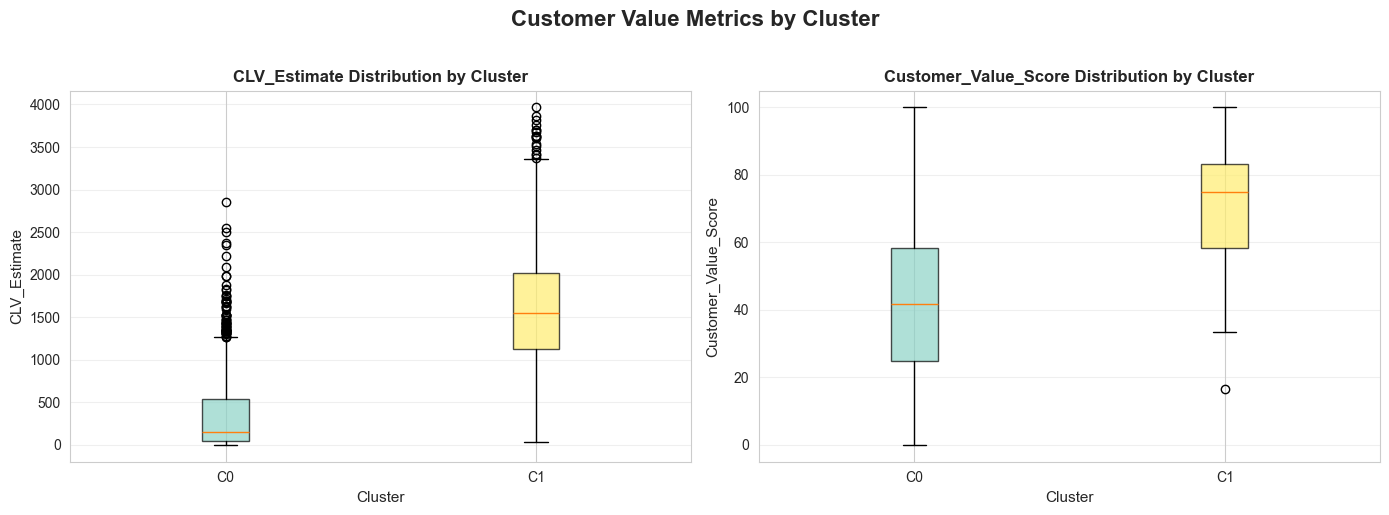

In [13]:
#  CUSTOMER VALUE ANALYSIS BY CLUSTER
value_features = ['CLV_Estimate', 'Customer_Value_Score']
available_value = [f for f in value_features if f in df.columns]

if available_value:
    fig, axes = plt.subplots(1, len(available_value), 
                            figsize=(7*len(available_value), 5))
    if len(available_value) == 1:
        axes = [axes]
    
    for idx, feat in enumerate(available_value):
        cluster_data = [df[df['Final_ML_Cluster'] == i][feat].dropna() for i in range(n_clusters)]
        
        bp = axes[idx].boxplot(cluster_data, labels=[f'C{i}' for i in range(n_clusters)],
                               patch_artist=True)
        
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        axes[idx].set_xlabel('Cluster', fontsize=11)
        axes[idx].set_ylabel(feat, fontsize=11)
        axes[idx].set_title(f'{feat} Distribution by Cluster', 
                           fontweight='bold', fontsize=12)
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Customer Value Metrics by Cluster', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step7_customer_value.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
#  STATISTICAL SIGNIFICANCE TESTING
significance_results = []
test_features = available_metrics
for feat in test_features:
    if feat in df.columns:
        cluster_groups = [df[df['Final_ML_Cluster'] == i][feat].dropna() for i in range(n_clusters)]
        
        if all(len(g) > 0 for g in cluster_groups):
            h_stat, p_value = stats.kruskal(*cluster_groups)
            significance_results.append({
                'Feature': feat,
                'H_Statistic': h_stat,
                'P_Value': p_value,
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })

significance_df = pd.DataFrame(significance_results).sort_values('P_Value')

print("\nStatistical Significance (Kruskal-Wallis Test):")
print("-" * 70)
print(significance_df.to_string(index=False))

significance_df.to_csv('D://My projects/customer_segmentation_project/outputs/reports/step7_statistical_significance.csv', index=False)
print("\n✓ Saved significance testing results")


Statistical Significance (Kruskal-Wallis Test):
----------------------------------------------------------------------
                 Feature  H_Statistic       P_Value Significant
         Avg_Order_Value  1235.259744 1.325760e-270         Yes
          Total_Spending  1232.792094 4.557657e-270         Yes
                 M_Score  1190.119058 8.564676e-261         Yes
            CLV_Estimate  1144.544174 6.880748e-251         Yes
                  Income  1090.345464 4.142395e-239         Yes
        Engagement_Score   649.110319 3.488185e-143         Yes
         Total_Purchases   588.009458 6.790177e-130         Yes
                 F_Score   582.364284 1.147632e-128         Yes
Campaign_Acceptance_Rate   358.459058  6.097078e-80         Yes
    Customer_Tenure_Days    12.774313  3.514117e-04         Yes
                     Age    10.904310  9.594079e-04         Yes
                 R_Score     0.480926  4.880031e-01          No

✓ Saved significance testing results


In [15]:
# CREATE CLUSTER PERSONAS
personas = {}

for cluster_id in range(n_clusters):
    cluster_data = df[df['Final_ML_Cluster'] == cluster_id]
    
    persona = {
        'Cluster_ID': cluster_id,
        'Size': len(cluster_data),
        'Percentage': f"{(len(cluster_data) / len(df) * 100):.1f}%",
    }
    
    # Add key characteristics
    if 'Age' in df.columns:
        persona['Avg_Age'] = cluster_data['Age'].mean()
    if 'Income' in df.columns:
        persona['Avg_Income'] = cluster_data['Income'].mean()
    if 'Total_Spending' in df.columns:
        persona['Avg_Spending'] = cluster_data['Total_Spending'].mean()
    if 'R_Score' in df.columns:
        persona['Avg_Recency_Score'] = cluster_data['R_Score'].mean()
    if 'F_Score' in df.columns:
        persona['Avg_Frequency_Score'] = cluster_data['F_Score'].mean()
    if 'M_Score' in df.columns:
        persona['Avg_Monetary_Score'] = cluster_data['M_Score'].mean()
    if 'CLV_Estimate' in df.columns:
        persona['Avg_CLV'] = cluster_data['CLV_Estimate'].mean()
    if 'Campaign_Acceptance_Rate' in df.columns:
        persona['Campaign_Response_Rate'] = cluster_data['Campaign_Acceptance_Rate'].mean()
    
    personas[f'Cluster_{cluster_id}'] = persona

personas_df = pd.DataFrame(personas).T
print("\nCluster Personas:")
print(personas_df.round(2).to_string())

personas_df.to_csv('D://My projects/customer_segmentation_project/outputs/reports/step7_cluster_personas.csv')
print("\n✓ Saved cluster personas")


Cluster Personas:
          Cluster_ID  Size Percentage    Avg_Age    Avg_Income Avg_Spending Avg_Recency_Score Avg_Frequency_Score Avg_Monetary_Score      Avg_CLV Campaign_Response_Rate
Cluster_0          0  1576      70.7%  54.581853  42425.102792   292.030457          3.027284            2.456218           2.331218   345.182677                0.03437
Cluster_1          1   653      29.3%  56.388974  73809.973966  1362.191424          2.981623            4.084227             4.6049  1659.607353               0.172282

✓ Saved cluster personas


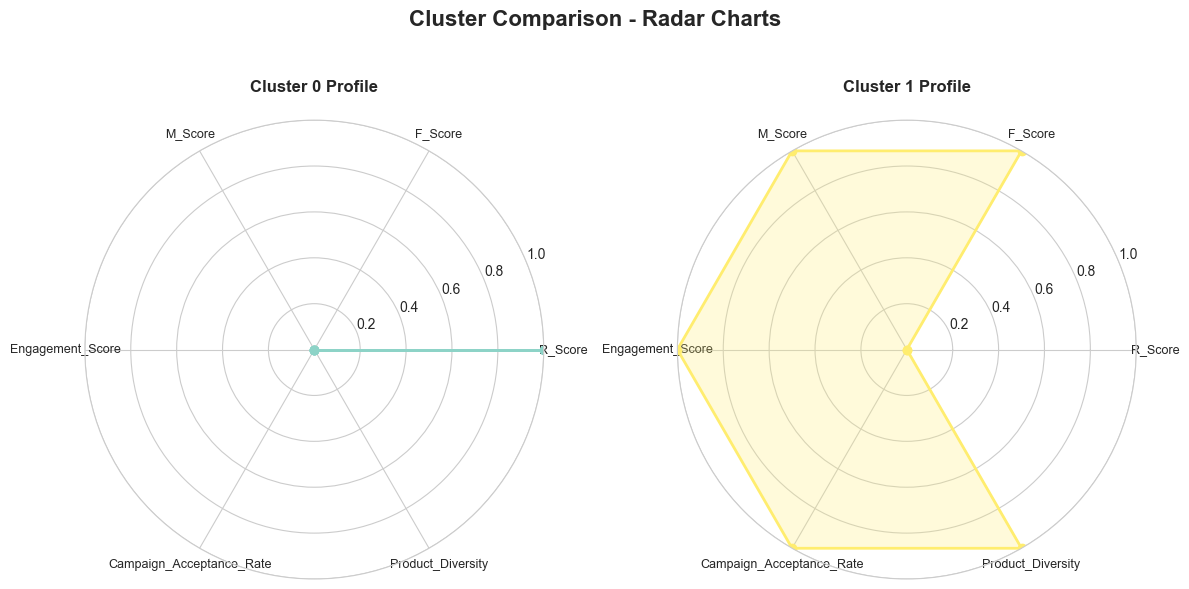

In [16]:
# RADAR CHART COMPARISON
radar_metrics = []
for metric in ['R_Score', 'F_Score', 'M_Score', 'Engagement_Score', 
               'Campaign_Acceptance_Rate', 'Product_Diversity']:
    if metric in df.columns:
        radar_metrics.append(metric)

if len(radar_metrics) >= 3:
    # Normalize metrics to 0-1 scale for comparison
    radar_data = df.groupby('Final_ML_Cluster')[radar_metrics].mean()
    radar_data_normalized = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())
    
    # Create radar chart
    from math import pi
    
    fig, axes = plt.subplots(1, n_clusters, figsize=(6*n_clusters, 6), 
                            subplot_kw=dict(projection='polar'))
    if n_clusters == 1:
        axes = [axes]
    
    categories = radar_metrics
    N = len(categories)
    
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    for idx, cluster_id in enumerate(range(n_clusters)):
        ax = axes[idx]
        
        values = radar_data_normalized.iloc[cluster_id].values.tolist()
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[idx], label=f'Cluster {cluster_id}')
        ax.fill(angles, values, alpha=0.25, color=colors[idx])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, size=9)
        ax.set_ylim(0, 1)
        ax.set_title(f'Cluster {cluster_id} Profile', fontweight='bold', fontsize=12, pad=20)
        ax.grid(True)
    
    plt.suptitle('Cluster Comparison - Radar Charts', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('D://My projects/customer_segmentation_project/outputs/figures/step7_radar_charts.png', dpi=300, bbox_inches='tight')
    plt.show()

In [17]:
# SUMMARY REPORT
print("SEGMENT PROFILING SUMMARY")
print("="*70)

for cluster_id in range(n_clusters):
    cluster_data = df[df['Final_ML_Cluster'] == cluster_id]
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id} PROFILE")
    print(f"{'='*70}")
    print(f"Size: {len(cluster_data)} customers ({len(cluster_data)/len(df)*100:.1f}%)")
    
    if 'Age' in df.columns:
        print(f"Average Age: {cluster_data['Age'].mean():.1f} years")
    if 'Income' in df.columns:
        print(f"Average Income: ${cluster_data['Income'].mean():,.0f}")
    if 'Total_Spending' in df.columns:
        print(f"Average Spending: ${cluster_data['Total_Spending'].mean():,.0f}")
    if 'Total_Purchases' in df.columns:
        print(f"Average Purchases: {cluster_data['Total_Purchases'].mean():.1f}")
    if 'CLV_Estimate' in df.columns:
        print(f"Average CLV: ${cluster_data['CLV_Estimate'].mean():,.0f}")
    
    print(f"\nRFM Profile:")
    if 'R_Score' in df.columns:
        print(f"  Recency Score: {cluster_data['R_Score'].mean():.2f}")
    if 'F_Score' in df.columns:
        print(f"  Frequency Score: {cluster_data['F_Score'].mean():.2f}")
    if 'M_Score' in df.columns:
        print(f"  Monetary Score: {cluster_data['M_Score'].mean():.2f}")
    
    if 'Campaign_Acceptance_Rate' in df.columns:
        print(f"\nCampaign Response Rate: {cluster_data['Campaign_Acceptance_Rate'].mean():.2%}")
    if 'Engagement_Score' in df.columns:
        print(f"Engagement Score: {cluster_data['Engagement_Score'].mean():.2f}")


SEGMENT PROFILING SUMMARY

CLUSTER 0 PROFILE
Size: 1576 customers (70.7%)
Average Age: 54.6 years
Average Income: $42,425
Average Spending: $292
Average Purchases: 12.3
Average CLV: $345

RFM Profile:
  Recency Score: 3.03
  Frequency Score: 2.46
  Monetary Score: 2.33

Campaign Response Rate: 3.44%
Engagement Score: 13.98

CLUSTER 1 PROFILE
Size: 653 customers (29.3%)
Average Age: 56.4 years
Average Income: $73,810
Average Spending: $1,362
Average Purchases: 21.0
Average CLV: $1,660

RFM Profile:
  Recency Score: 2.98
  Frequency Score: 4.08
  Monetary Score: 4.60

Campaign Response Rate: 17.23%
Engagement Score: 23.72
